## imports

In [ ]:
import neurokit2 as nk
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt 
import xgboost as xgb
import seaborn as sns
import shap
import scipy.stats as stats
from datetime import datetime, timedelta
import re
from scipy.stats import linregress, ttest_rel, wilcoxon, zscore
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, classification_report, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from xgboost import XGBClassifier
import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from tqdm import tqdm
import warnings
import statsmodels.api as sm
from statsmodels.formula.api import ols, mixedlm
from statsmodels.regression.mixed_linear_model import MixedLM
from xlogit import MixedLogit as xl
import matplotlib.patches as mpatches
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import GroupKFold


warnings.filterwarnings("ignore", category=UserWarning)
xgb.set_config(verbosity=0)  # Suppresses XGBoost warnings

# Specify the path to the desired directory
parent_dir = r'<<< PLACE HERE DIRECTORY WITH DATASET >>>'


# Change the current working directory to the specified directory
os.chdir(parent_dir)

all_ratings_BEWSFB = pd.read_csv("processed_data_anonymized.csv", sep=",")

# Verify that the working directory has been changed
print("Current working directory:", os.getcwd())

C:\Users\BootMR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Current working directory: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER


## prepare for classifications

In [66]:
hrv_features = [
    'H10_hr_mean', 'H10_hr_stdev', 'H10_hrv_mean', 'H10_hrv_stdev', 'H10_HRV_MeanNN', 'H10_HRV_RMSSD', 'H10_HRV_LF', 'H10_HRV_HF', 'H10_HRV_LFHF'
]

eda_features = [
    'E4_eda_tonic_mean', 'E4_eda_tonic_std', 'E4_eda_tonic_peaks', 'E4_eda_phasic_mean', 'E4_eda_phasic_std', 'E4_eda_phasic_peaks'
]

selected_features = [
    'p_id', 'rating_totalperpid', 'H10_hr_mean', 'H10_hrv_mean', 'H10_HRV_RMSSD', 'H10_HRV_MeanNN', 'H10_HRV_HF', 'H10_HRV_SD1', 'H10_HRV_SD2', 'E4_eda_phasic_mean', 'E4_eda_phasic_peaks', 'E4_eda_phasic_max', 'E4_eda_phasic_n_above_mean', 'E4_eda_tonic_mean', 'E4_eda_tonic_peaks', 'E4_eda_tonic_n_above_mean', 'cadence_avg', 'velocity_avg', 'velocity_avg_change', 'warnings_slowdown_count', 'warnings_tactile_warning', 'warnings_audio_warning', 'warnings_warning_value', 'sociodem_income', 'sociodem_education', 'sociodem_cycling_experience', 'sociodem_BMI', 'sociodem_fitness', 'sociodem_mood', 'sociodem_pleasantness_disposition', 'context_surface_type', 'context_road_quality', 'context_scenic_beauty', 'context_hindrance', 'context_road_type', 'weather_temperature', 'weather_wind_speed', 'context_perceivedinfluence', 'cycling_perceivedintensity'
]

extended_features = [
    #everything from selected
    'p_id', 'rating_totalperpid', 'H10_hr_mean', 'H10_hrv_mean', 'H10_HRV_RMSSD', 'H10_HRV_MeanNN', 'H10_HRV_HF', 'H10_HRV_SD1', 'H10_HRV_SD2', 
    'E4_eda_phasic_mean', 'E4_eda_phasic_peaks', 'E4_eda_phasic_max', 'E4_eda_phasic_n_above_mean', 'E4_eda_tonic_mean', 'E4_eda_tonic_peaks', 'E4_eda_tonic_n_above_mean', 
    'cadence_avg', 'velocity_avg', 'velocity_avg_change', 
    'warnings_slowdown_count', 'warnings_tactile_warning', 'warnings_audio_warning', 'warnings_warning_value', 
    'sociodem_income', 'sociodem_education', 'sociodem_income', 'sociodem_education', 'sociodem_cycling_experience', 'sociodem_BMI', 'sociodem_fitness', 'sociodem_mood', 'sociodem_pleasantness_disposition', 
    'context_surface_type', 'context_road_quality', 'context_scenic_beauty', 'context_hindrance', 'context_road_type', 
    'temperature', 'weather_wind_speed',
    'context_perceivedinfluence', 'cycling_perceivedintensity',    
    #plus: 
    'H10_HRV_LF', 'H10_HRV_LFHF',
    'E4_hrv_rmssd', 'E4_hrv_mean_hr', 'E4_hrv_lf', 'E4_hrv_hf', 'E4_hrv_lf_hf_ratio', 'E4_hrv_std',
    'E4_acc_acc_x_mean', 'E4_acc_acc_x_std', 'E4_acc_acc_x_skewness', 'E4_acc_acc_y_std', 'E4_acc_acc_y_skewness',
    'E4_acc_acc_z_mean', 'E4_acc_acc_z_std', 'E4_acc_acc_z_skewness', 'E4_acc_l2_mean', 'E4_acc_l2_std', 'E4_acc_l2_skewness',
    'cadence_min', 'cadence_max', 'cadence_std', 'cadence_avgacc', 'cadence_slope', 'cadence_cv', 'cadence_skewness', 'cadence_kurtosis',
    'cadence_pvr', 
    'velocity_cv', 'velocity_skewness', 'velocity_kurtosis', 'velocity_slope',
    'humidity', 'cloudiness', 'rain_3h', 'wind_direction',
    'Nationality', 'gender', 'length', 'coffee', 
]

In [ ]:
# worked well: 11th March

# script part 1 - setup

all_ratings_BEWSFB["rating_weight"] = 1 / all_ratings_BEWSFB.groupby("p_id")["p_id"].transform("count")

# Adjust the weight for negative ratings (e.g., multiply by a factor)
weight_factor = 1  # Adjust this factor based on how much more weight you want to give to -1 ratings

# Increase the weight for rows where rating is -1
all_ratings_BEWSFB["rating_weight"] = all_ratings_BEWSFB.apply(
    lambda row: row["rating_weight"] * weight_factor if row["rating"] == -1 else row["rating_weight"], axis=1
)

# Set desired sample size (adjust as needed)
sample_size = 600  # Example: selecting 300 samples

# Perform weighted random sampling based on rating_weight
sampled_df = all_ratings_BEWSFB.sample(n=sample_size, weights="rating_weight", random_state=42)

# Check the distribution of sampled participants
#print(sampled_df["p_id"].value_counts())

# Set participant IDs to exclude
pids_exclude = []  # Example
sampled_df = sampled_df[~sampled_df['p_id'].astype(str).isin(pids_exclude)]

# Encode categorical variables
label_encoders = {}
categorical_columns = sampled_df.select_dtypes(include=['object']).columns
for col in categorical_columns:
    le = LabelEncoder()
    sampled_df[col] = le.fit_transform(sampled_df[col].astype(str))
    label_encoders[col] = le

# Define target variables
y_binary = sampled_df.loc[sampled_df['rating'].isin([-1, 1]), 'rating'].map({-1: 0, 1: 1})
y_multiclass = sampled_df['rating'].map({-1: 0, 0: 1, 1: 2})

X_binary = sampled_df.loc[y_binary.index]
X_multiclass = sampled_df.loc[y_multiclass.index]

# Feature sets
feature_sets = {
    'H10 HRV': hrv_features,
    'E4 EDA': eda_features,
    'Selected': selected_features,
    'Extended': extended_features
}

# Hyperparameter grids
param_grids = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'SVM (RBF)': {'C': [0.1, 1.0], 'kernel': ['rbf']},
    'XGBoost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}
}

In [18]:
# script part 2 - run model

# Store results
results = []

# Get total iterations for tqdm
total_iterations = len(feature_sets) * 2 * 4 # (Feature sets) * (Binary + 3-Class) * (4 models)
progress_bar = tqdm(total=total_iterations, desc="Total Progress", unit="iteration")

# Cross-validation setup (10-fold)
#old: cv = StratifiedKFold(n_splits=50, shuffle=True, random_state=42)
#new way of splitting on participant level:
cv = GroupKFold(n_splits=10)  # 10 folds is usually enough for group CV

# Loop over binary and multiclass tasks
for task, (X_task, y_task) in [('Binary', (X_binary, y_binary)), ('3-Class', (X_multiclass, y_multiclass))]:
    for feature_set_name, feature_list in feature_sets.items():
        #print(feature_set_name)
        # Ensure only existing columns are used
        feature_list = [col for col in feature_list if col in X_task.columns]
        X = X_task[feature_list]

        X = X_task[feature_list].copy()
        if 'p_id' in X.columns:
            X = X.drop(columns=['p_id'])  # don't use it as a feature

        # Handle missing values
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(X)

        # Feature scaling
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        for model_name in ['Logistic Regression', 'Random Forest', 'SVM (RBF)', 'XGBoost']:
            #print(model_name)
            # Model selection
            if model_name == 'Random Forest':
                model = RandomForestClassifier()
            elif model_name == 'SVM (RBF)':
                model = SVC(probability=True)
            elif model_name == 'XGBoost':
                model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            else:
                model = LogisticRegression(max_iter=1000)

            # Hyperparameter tuning if available
            if model_name in param_grids:
                model = GridSearchCV(model, param_grid=param_grids[model_name], scoring='f1_weighted', cv=3)
                model.fit(X, y_task)
                best_model = model.best_estimator_
            else:
                best_model = model

            # Cross-validation evaluation
            f1_scores = []
            groups = X_task['p_id']  # assumes p_id is still in X_task

            for train_idx, val_idx in cv.split(X, y_task, groups=groups):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y_task.to_numpy()[train_idx], y_task.to_numpy()[val_idx]

                best_model.fit(X_train, y_train)
                y_pred = best_model.predict(X_val)
                f1_scores.append(f1_score(y_val, y_pred, average='weighted'))

            avg_f1 = np.mean(f1_scores)

            # Store results
            results.append({
                'Feature Set': feature_set_name,
                'Classification Type': task,
                'Model': model_name,
                'F1 Score': avg_f1
            })

            # Update progress bar
            progress_bar.update(1)

progress_bar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot table for visualization
pivot_f1 = results_df.pivot_table(values='F1 Score', index=['Feature Set', 'Classification Type'], columns='Model')

# Copy results to clipboard for Excel
pivot_f1.to_clipboard(excel=True)

print("F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.")

Total Progress: 100%|██████████| 32/32 [02:05<00:00,  3.93s/iteration]

F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.


In [68]:


# Store results
results = []

# Total model runs = (Feature sets) * (Binary + 3-Class) * (4 models)
total_iterations = len(feature_sets) * 2 * 4
progress_bar = tqdm(total=total_iterations, desc="Total Progress (LOOCV)", unit="iteration")

# Loop over binary and multiclass tasks
for task, (X_task, y_task) in [('Binary', (X_binary, y_binary)), ('3-Class', (X_multiclass, y_multiclass))]:
    for feature_set_name, feature_list in feature_sets.items():
        # Filter feature list to those present in the current data
        feature_list = [col for col in feature_list if col in X_task.columns]
        X = X_task[feature_list].copy()

        # Drop 'p_id' if still in features
        if 'p_id' in X.columns:
            X = X.drop(columns=['p_id'])

        groups = X_task['p_id']

        # Impute missing values
        imputer = SimpleImputer(strategy='mean')
        X = imputer.fit_transform(X)

        # Scale features
        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        # Use Leave-One-Group-Out CV (1 participant per fold)
        unique_groups = np.unique(groups)
        cv = GroupKFold(n_splits=len(unique_groups))  # One fold per participant

        for model_name in ['Logistic Regression', 'Random Forest', 'SVM (RBF)', 'XGBoost']:
            # Select model
            if model_name == 'Random Forest':
                model = RandomForestClassifier()
            elif model_name == 'SVM (RBF)':
                model = SVC(probability=True)
            elif model_name == 'XGBoost':
                model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
            else:
                model = LogisticRegression(max_iter=1000)

            # Optional hyperparameter tuning
            if model_name in param_grids:
                model = GridSearchCV(model, param_grid=param_grids[model_name], scoring='f1_weighted', cv=3)
                model.fit(X, y_task)
                best_model = model.best_estimator_
            else:
                best_model = model

            # Leave-One-Group-Out Cross-Validation
            f1_scores = []

            for train_idx, val_idx in cv.split(X, y_task, groups=groups):
                X_train, X_val = X[train_idx], X[val_idx]
                y_train, y_val = y_task.to_numpy()[train_idx], y_task.to_numpy()[val_idx]

                best_model.fit(X_train, y_train)
                y_pred = best_model.predict(X_val)

                f1 = f1_score(y_val, y_pred, average='weighted')
                f1_scores.append(f1)

            avg_f1 = np.mean(f1_scores)

            # Store results
            results.append({
                'Feature Set': feature_set_name,
                'Classification Type': task,
                'Model': model_name,
                'F1 Score': avg_f1
            })

            # Update progress bar
            progress_bar.update(1)

progress_bar.close()

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create pivot table for visualization
pivot_f1 = results_df.pivot_table(
    values='F1 Score',
    index=['Feature Set', 'Classification Type'],
    columns='Model'
)

# Copy results to clipboard (optional)
pivot_f1.to_clipboard(excel=True)
print("F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.")


Total Progress (LOOCV): 100%|██████████| 32/32 [03:59<00:00,  7.48s/iteration]

F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.


In [69]:
# Copy results to clipboard (optional)
pivot_f1.to_clipboard(excel=True)
print("F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.")

F1 scores copied to clipboard. Paste (Ctrl+V) into Excel.


## probabilty distributions

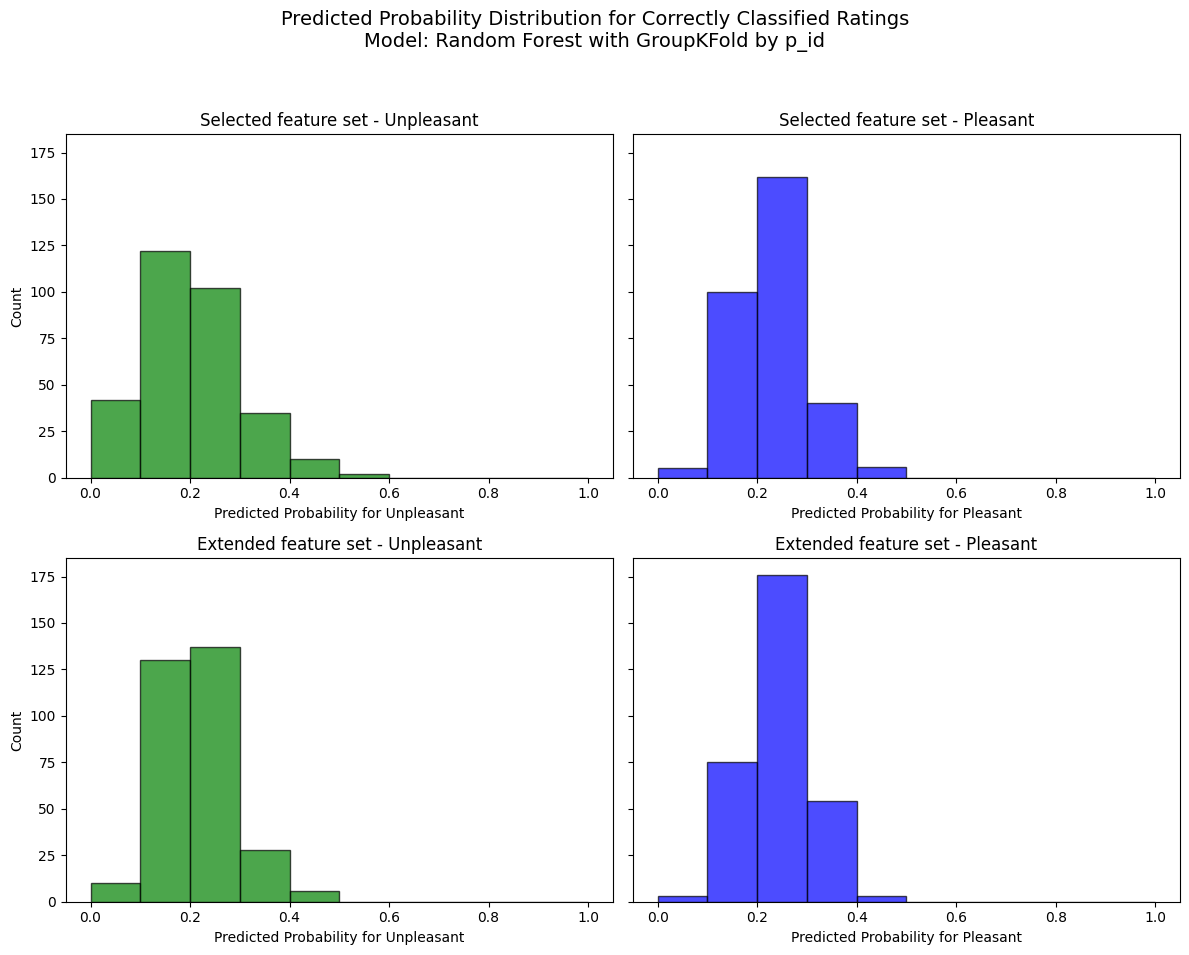

In [61]:

# Weighted sampling based on number of ratings per participant
all_ratings_BEWSFB["rating_weight"] = 1 / all_ratings_BEWSFB.groupby("p_id")["p_id"].transform("count")
sample_size = 600
sampled_df = all_ratings_BEWSFB.sample(n=sample_size, weights="rating_weight", random_state=42)

# Define feature sets
feature_sets = {
    "Selected feature set": selected_features,
    "Extended feature set": extended_features
}

# Initialize model
model = RandomForestClassifier(n_estimators=100, max_depth=None, random_state=42)

# Prepare labels and groups
X_binary = sampled_df.drop(columns=["rating", "rating_weight", "p_id"])
y_binary = sampled_df["rating"]  # Assume binary label (0=Unpleasant, 1=Pleasant)
groups = sampled_df["p_id"]

# GroupKFold for participant-level splitting
cv = GroupKFold(n_splits=10)

# Store results for each feature set
probability_results = {}

for feature_set_name, feature_list in feature_sets.items():
    # Ensure features exist in data
    feature_list = [col for col in feature_list if col in X_binary.columns]
    X = X_binary[feature_list]
    
    # Handle missing values
    imputer = SimpleImputer(strategy="mean")
    X = imputer.fit_transform(X)
    
    # Feature scaling
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    
    # Store predicted probabilities for correct classifications
    probabilities_unpleasant = []
    probabilities_pleasant = []

    for train_idx, val_idx in cv.split(X, y_binary, groups=groups):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y_binary.to_numpy()[train_idx], y_binary.to_numpy()[val_idx]

        model.fit(X_train, y_train)
        y_pred_proba = model.predict_proba(X_val)
        y_pred = model.predict(X_val)

        # Get correct classifications
        correct_idx = y_pred == y_val
        probabilities_unpleasant.extend(y_pred_proba[correct_idx, 0])
        probabilities_pleasant.extend(y_pred_proba[correct_idx, 1])

    probability_results[feature_set_name] = {
        "prob_unpleasant": np.array(probabilities_unpleasant),
        "prob_pleasant": np.array(probabilities_pleasant)
    }

# Create figure with histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 10), sharey=True)

for i, (feature_set_name, data) in enumerate(probability_results.items()):
    row = i

    # Unpleasant (Class 0)
    axes[row, 0].hist(data["prob_unpleasant"], bins=np.arange(0, 1.1, 0.1),
                      edgecolor="black", color="green", alpha=0.7)
    axes[row, 0].set_xlabel("Predicted Probability for Unpleasant")
    axes[row, 0].set_ylabel("Count")
    axes[row, 0].set_title(f"{feature_set_name} - Unpleasant")

    # Pleasant (Class 1)
    axes[row, 1].hist(data["prob_pleasant"], bins=np.arange(0, 1.1, 0.1),
                      edgecolor="black", color="blue", alpha=0.7)
    axes[row, 1].set_xlabel("Predicted Probability for Pleasant")
    axes[row, 1].set_title(f"{feature_set_name} - Pleasant")

plt.suptitle("Predicted Probability Distribution for Correctly Classified Ratings\nModel: Random Forest with GroupKFold by p_id", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


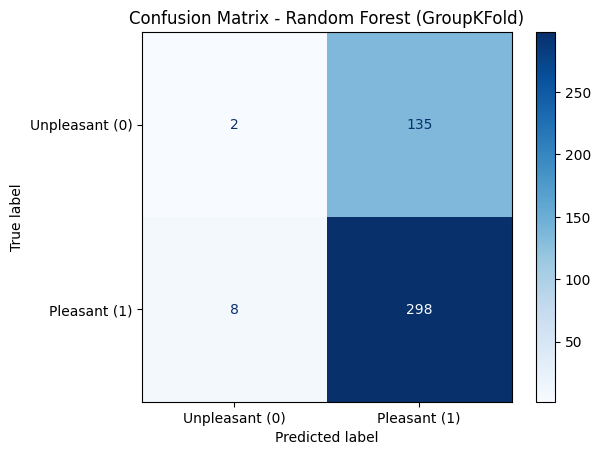

In [62]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Prepare data for confusion matrix (using the Selected feature set)
feature_list = [col for col in selected_features if col in X_binary.columns]
X = X_binary[feature_list]

# Impute and scale
imputer = SimpleImputer(strategy="mean")
X = imputer.fit_transform(X)
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Store all predictions and true labels
y_true_all = []
y_pred_all = []

for train_idx, val_idx in cv.split(X, y_binary, groups=groups):
    X_train, X_val = X[train_idx], X[val_idx]
    y_train, y_val = y_binary.to_numpy()[train_idx], y_binary.to_numpy()[val_idx]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    y_true_all.extend(y_val)
    y_pred_all.extend(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true_all, y_pred_all, labels=[0, 1])

# Plot
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Unpleasant (0)", "Pleasant (1)"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest (GroupKFold)")
plt.show()


## classif diff windowlengths

In [12]:


# File paths
merged_files = [
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_30s.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_60s1.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_60s2.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_ECGfeatures_120s.csv"
]


# File paths
merged_files = [
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_30s.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_60s1.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_60s2.csv",
    r"C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_120s.csv"
]


# Feature definitions
hrv_features = [
    'hr_mean', 'hr_stdev', 'hrv_mean', 'hrv_stdev',
    'HRV_MeanNN', 'HRV_RMSSD', 'HRV_LF', 'HRV_HF', 'HRV_LFHF'
]

eda_features = [
    'eda_tonic_mean', 'eda_tonic_std', 'eda_tonic_peaks', 'eda_phasic_mean', 'eda_phasic_std', 'eda_phasic_peaks'
]


# Hyperparameter grids
param_grids = {
    'Random Forest': {'n_estimators': [50, 100], 'max_depth': [None, 10]},
    'SVM (RBF)': {'C': [0.1, 1.0], 'kernel': ['rbf']},
    'XGBoost': {'learning_rate': [0.01, 0.1], 'n_estimators': [50, 100]}
}

# Store results
results = []

for file_path in merged_files:
    print(f"\nProcessing: {file_path}")
    sampled_df = pd.read_csv(file_path)

    sampled_df["rating_weight"] = 1 / sampled_df.groupby("p_id")["p_id"].transform("count")
    sample_size = 600
    sampled_df = sampled_df.sample(n=sample_size, weights="rating_weight", random_state=42)

    # Binary classification
    sampled_df = sampled_df[sampled_df['rating'].isin([-1, 1])]
    y_binary = sampled_df['rating'].map({-1: 0, 1: 1})
    groups = sampled_df["p_id"]


    feature_list = [col for col in eda_features if col in sampled_df.columns]
    if not feature_list:
        print(f"Warning: No HRV features found in {file_path}. Skipping.")
        continue

    X_binary = sampled_df[feature_list]

    # Handle missing values
    imputer = SimpleImputer(strategy='mean')
    X_binary = imputer.fit_transform(X_binary)

    # Feature scaling
    scaler = StandardScaler()
    X_binary = scaler.fit_transform(X_binary)

    # Group-level cross-validation setup (10 folds by participant)
    cv = GroupKFold(n_splits=10)

    for model_name in ['Logistic Regression', 'Random Forest', 'SVM (RBF)', 'XGBoost']:
        print(f"  Training model: {model_name}")

        # Model selection
        if model_name == 'Random Forest':
            model = RandomForestClassifier()
        elif model_name == 'SVM (RBF)':
            model = SVC(probability=True)
        elif model_name == 'XGBoost':
            model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
        else:
            model = LogisticRegression(max_iter=1000)

        # Hyperparameter tuning
        if model_name in param_grids:
            grid = GridSearchCV(model, param_grid=param_grids[model_name], scoring='f1_weighted', cv=3)
            grid.fit(X_binary, y_binary)
            best_model = grid.best_estimator_
        else:
            best_model = model

        # Cross-validation evaluation
        f1_scores = []
        conf_matrices = []

        for train_idx, val_idx in cv.split(X_binary, y_binary, groups=groups):
            X_train, X_val = X_binary[train_idx], X_binary[val_idx]
            y_train, y_val = y_binary.to_numpy()[train_idx], y_binary.to_numpy()[val_idx]

            best_model.fit(X_train, y_train)
            y_pred = best_model.predict(X_val)

            f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
            conf_matrices.append(confusion_matrix(y_val, y_pred))

        avg_f1 = np.mean(f1_scores)
        avg_conf_matrix = np.mean(conf_matrices, axis=0)

        results.append({
            'file': file_path,
            'Feature Set': 'hrv',
            'Model': model_name,
            'F1 Score': avg_f1
        })

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Pivot table for easier visualization in Excel
pivot_f1 = results_df.pivot_table(values='F1 Score', index=['file', 'Feature Set'], columns='Model')

# Copy results to clipboard for Excel
pivot_f1.to_clipboard(excel=True)

print("\nF1 scores copied to clipboard. Paste (Ctrl+V) into Excel.")



Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_30s.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_60s1.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_60s2.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

Processing: C:\Users\BootMR\Documents\data_processed\CHECKIFYOUREALLYNEEDTHISFOLDER\merged_Flirtfeatures_120s.csv
  Training model: Logistic Regression
  Training model: Random Forest
  Training model: SVM (RBF)
  Training model: XGBoost

F1 scores copied to clipboard. Paste (Ctrl+V

## xgb shap beeswarm

C:\Users\BootMR\AppData\Local\Temp\ipykernel_13796\1573268086.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['rating'] = df_filtered['rating'].replace(-1, 0)  # Map -1 to 0
C:\Users\BootMR\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


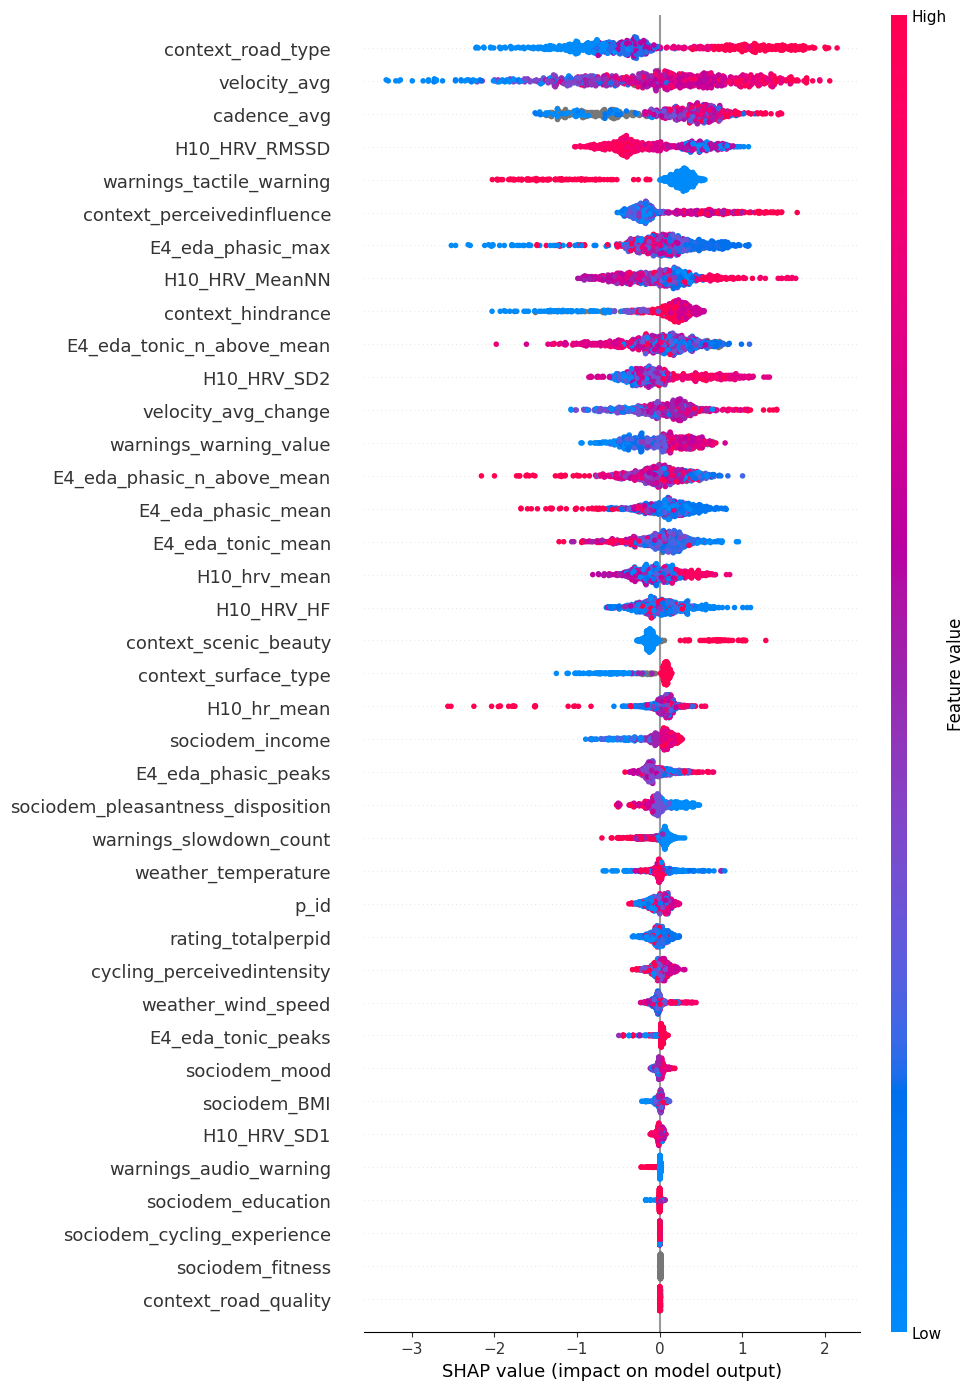

In [25]:

variables = [

    'p_id', 'rating_totalperpid', 'H10_hr_mean', 'H10_hrv_mean', 'H10_HRV_RMSSD', 'H10_HRV_MeanNN', 'H10_HRV_HF', 'H10_HRV_SD1', 'H10_HRV_SD2', 'E4_eda_phasic_mean', 'E4_eda_phasic_peaks', 'E4_eda_phasic_max', 'E4_eda_phasic_n_above_mean', 'E4_eda_tonic_mean', 'E4_eda_tonic_peaks', 'E4_eda_tonic_n_above_mean', 'cadence_avg', 'velocity_avg', 'velocity_avg_change', 'warnings_slowdown_count', 'warnings_tactile_warning', 'warnings_audio_warning', 'warnings_warning_value', 'sociodem_income', 'sociodem_education', 'sociodem_cycling_experience', 'sociodem_BMI', 'sociodem_fitness', 'sociodem_mood', 'sociodem_pleasantness_disposition', 'context_surface_type', 'context_road_quality', 'context_scenic_beauty', 'context_hindrance', 'context_road_type', 'weather_temperature', 'weather_wind_speed', 'context_perceivedinfluence', 'cycling_perceivedintensity'
]



df_filtered = all_ratings_BEWSFB[all_ratings_BEWSFB['rating'] != 0]

df_filtered['rating'] = df_filtered['rating'].replace(-1, 0)  # Map -1 to 0

X = df_filtered[variables]  # Select features
y = df_filtered['rating']   # Define target variable

# Train XGBoost model
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')  # Avoid warning
model.fit(X, y)

# Compute SHAP values
explainer = shap.Explainer(model, X)
shap_values = explainer(X)


# Generate beeswarm plot for selected features
shap.plots.beeswarm(shap_values, max_display=len(variables))